In [1]:
FEAT_PATH_PQT = '/kaggle/input/feat-check/city_weeks.pqt'
FEAT_PATH_CSV =  ''
DROP_LIST = ['age', 'user_id', 'is_male', 'vih_list', 'bud_list']
RAND = sum(ord(x) for x in 'NEVER SURRENDER')

CAT_FEATURES = []

In [2]:
import pandas as pd
import shap

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('/kaggle/input/feat-check/train_feat.csv')
try:
    test_features = pd.read_parquet(FEAT_PATH_PQT)
except:
    test_features = pd.read_parquet(FEAT_PATH_CSV)
df = df.merge(test_features, on='user_id')

In [4]:
df['target'] = df['is_male']
df = df.drop(DROP_LIST, axis=1)
df = df.dropna()

In [11]:
try:
    lr_model = LogisticRegression(random_state=RAND, solver='saga', penalty='l1', C=5, max_iter=1000)
    lr_model.fit(df.drop('target', axis=1), df['target'])
except:
    lr_model = False

In [6]:
train, valid = train_test_split(df, 
                                test_size=0.3, 
                                stratify=df['target'], 
                                random_state=RAND)

train_pool = Pool(train.drop('target', axis=1),
                  train['target'], 
                  cat_features=CAT_FEATURES)

valid_pool = Pool(valid.drop('target', axis=1),
                  valid['target'], 
                  cat_features=CAT_FEATURES)

In [7]:
cat_model = CatBoostClassifier(random_state=RAND,
                               verbose=250)
cat_model.fit(train_pool, eval_set=valid_pool)

Learning rate set to 0.115058
0:	learn: 0.6908681	test: 0.6907621	best: 0.6907621 (0)	total: 110ms	remaining: 1m 50s
250:	learn: 0.6537511	test: 0.6645326	best: 0.6645326 (250)	total: 8.12s	remaining: 24.2s
500:	learn: 0.6423764	test: 0.6642175	best: 0.6639122 (423)	total: 16s	remaining: 15.9s
750:	learn: 0.6334311	test: 0.6644980	best: 0.6639122 (423)	total: 23.9s	remaining: 7.91s
999:	learn: 0.6258559	test: 0.6652336	best: 0.6639122 (423)	total: 32s	remaining: 0us

bestTest = 0.6639122494
bestIteration = 423

Shrink model to first 424 iterations.


_________________________
## RESULTS

In [16]:
if lr_model:
    display(pd.DataFrame(lr_model.coef_, columns=df.drop('target', axis=1).columns).T)

,0
f1,0.253244
f2,0.125068
f3,-0.139975
f4,-0.188306
f5,-0.235956
f6,-1.685663
f7,-0.061005
f8,0.137353
f9,0.314830
f10,-0.081333


In [9]:
cat_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,f6,16.158731
1,f1,14.053187
2,f2,8.864593
3,f5,7.804381
4,f4,7.734499
5,f8,7.675856
6,f7,7.062828
7,f3,6.659772
8,f9,6.409400
9,diff,6.143643


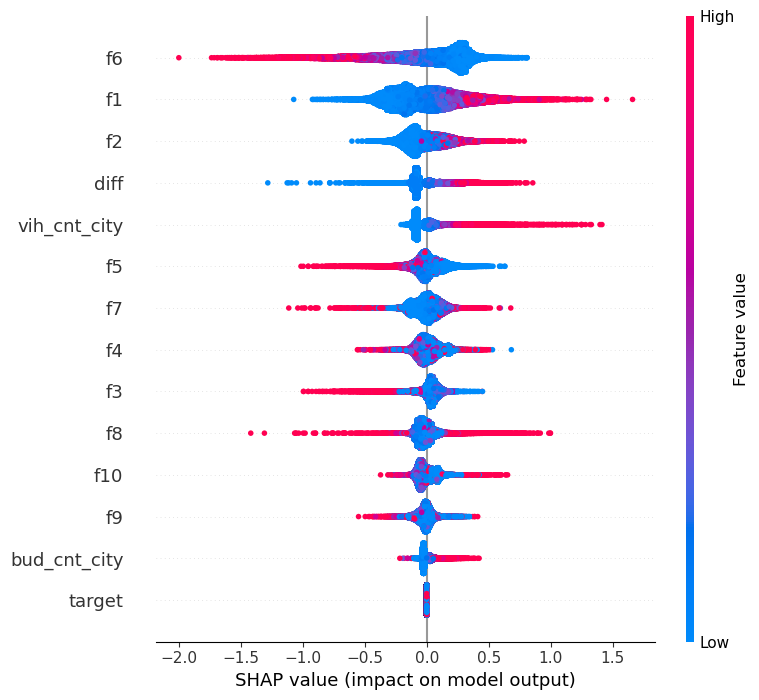

In [10]:
shap_test = shap.TreeExplainer(cat_model).shap_values(valid)
shap.summary_plot(shap_test, valid)